In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# !pip install sentence-transformers
# !pip install contractions
# !pip install gibberish_detector

In [23]:
import re
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize,sent_tokenize

import contractions
from gibberish_detector import detector

import pkg_resources
import itertools

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

Detector = detector.create_from_model('/content/drive/MyDrive/Sentiment_Analysis/gibberish-detector.model')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
df1 = pd.read_csv('/content/drive/MyDrive/Reviews_data/labelled_reviews/training/EMICalculatorFinanceTool_90days.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Reviews_data/labelled_reviews/training/FinancialCalculatorforGST_90days.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Reviews_data/labelled_reviews/training/HugeDigitalClock_90days.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Reviews_data/labelled_reviews/training/CloneArmiesBattleGame_90days.csv')
df5 = pd.read_csv('/content/drive/MyDrive/Reviews_data/labelled_reviews/training/HindiEnglishTranslator_90days.csv', encoding = 'ISO-8859-1')
df = df3.append(df4)
df = df.append(df5)
df['content'] = df['en_content'].tolist()
df.drop(['en_content'], axis=1, inplace=True)

df = df.append(df1)
df = df.append(df2)
df = df.fillna(0)
df.sort_values(by = 'thumbsUpCount', ascending=False, inplace=True)
imp_reviews = df[df['thumbsUpCount']>0].drop_duplicates()

print(len(df), len(imp_reviews))

3379 558


# Convert reviews to vectors

In [25]:
labels = ['Functionality', 'User Experience', 'Performance', 'Customer Support', 'Subscription', 'Feature Request']

In [26]:
df.head()

,reviewId,userName,userImage,content,rating,thumbsUpCount,Functionality,User Experience,Performance,Customer Support,Subscription,Feature Request,Funtionality
50,acf11feb-d690-4b0f-acc6-054e29c9ada3,Aditi Sarkar,https://play-lh.googleusercontent.com/a-/AFdZu...,I had no options when I had to translate langu...,5,1123,0.0,1.0,0.0,0.0,0.0,0.0,1.0
147,3a2384e3-e7e2-472a-b5c1-c3ff528365f2,Madhavi Choudhary,https://play-lh.googleusercontent.com/a/AItbvm...,This app is good for translation of language. ...,4,715,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107,430e0c64-0b20-4389-9001-657ed93e63b4,Manoj Anthwal,https://play-lh.googleusercontent.com/a/AItbvm...,I rate this app 4 star because I like this app...,4,659,0.0,0.0,1.0,0.0,0.0,1.0,1.0
106,44b8296b-9913-49d9-b640-39e20210350a,Khushi Jat,https://play-lh.googleusercontent.com/a/AItbvm...,Although the app is amazing but the multi lang...,3,333,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,fdf9e272-4de5-4c03-b5f9-2403caf4c5f8,Arvind Goswami Arvind Goswami,https://play-lh.googleusercontent.com/a/AItbvm...,Sir this app should also have a function to fi...,5,281,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
# adjectives = []
# for synset in list(wn.all_synsets(wn.ADJ)):
#     adjectives.extend(synset.lemma_names())

# stop_words = set(stopwords.words('english'))
# stop_words = stop_words.union(adjectives)

# adjectives = ['good', 'bad', 'worst', 'nice', 'best', 'very', 'love']

def max_seq(sent, n=2):
    sent = re.sub(' +', ' ', sent)
    clean_word_list = []
    for text in sent.split(' '):
        result = []
        for k, g in itertools.groupby(text):
            result.extend(list(g)[:n])
        result = ''.join(result)
        clean_word_list.append(result)
    return ' '.join(clean_word_list)

def clean_text(txt):
    if isinstance(txt, type(np.nan)):
        txt = ''
    txt = txt.lower()
    txt = max_seq(txt)        
    txt = contractions.fix(txt, slang=True)        
    txt = re.sub(r'[^a-zA-Z0-9 ]', ' ', txt)
    txt = [word for word in word_tokenize(txt) if not Detector.is_gibberish(word)]
    # txt = [lemmatizer.lemmatize(word) for word in word_tokenize(txt) if not Detector.is_gibberish(word)]
    return ' '.join(txt)

df['cleaned_text'] = df['content'].apply(clean_text)
imp_reviews['cleaned_text'] = imp_reviews['content'].apply(clean_text)
corpus = df['cleaned_text'].tolist()
Y = np.array(df[labels])
len(df)

3379

In [28]:
train_corpus, test_corpus, y_train, y_test = train_test_split(corpus, Y, test_size = 0.3, random_state = 1)
print(y_train.shape, y_test.shape)
train_corpus.extend(imp_reviews['cleaned_text'].tolist())
y_train = np.vstack((y_train, np.array(imp_reviews[labels])))
print(y_train.shape, y_test.shape)

(2365, 6) (1014, 6)
(2923, 6) (1014, 6)


In [29]:
train_vectors = model.encode(train_corpus)
test_vectors = model.encode(test_corpus)

print(train_vectors.shape, test_vectors.shape)

(2923, 384) (1014, 384)


In [30]:
type(train_vectors)

numpy.ndarray

# Model Training

In [31]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# device = torch.device("cuda:0")

In [32]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = y.type(torch.float32)
    y_hat = y_hat.type(torch.float32)
    tp = torch.sum(y_hat * y, dim = 0)
    fp = torch.sum(y_hat * (1 - y), dim=0)
    fn = torch.sum((1 - y_hat) * y, dim=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = torch.mean(cost) # average on all labels
    
    return macro_cost

def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = (y_hat>thresh).type(torch.float32)
    tp = torch.sum(y_hat * y, dim = 0)
    fp = torch.sum(y_hat * (1 - y), dim=0)
    fn = torch.sum((1 - y_hat) * y, dim=0)
    return tp, fp, fn

In [33]:
X_train, y_train = torch.tensor(train_vectors).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(test_vectors).float(), torch.tensor(y_test).float()

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

trainset = DataLoader(train_data, batch_size = 64, shuffle = True)
testset = DataLoader(test_data, batch_size = 64, shuffle = False)

In [34]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Linear(16,8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            nn.Linear(8,6)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return torch.sigmoid(x)

In [35]:
net = Net(train_vectors.shape[1])
print(net)

Net(
  (layers): Sequential(
    (0): Linear(in_features=384, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=8, out_features=6, bias=True)
  )
)


In [36]:
best_val_acc = 0.0

In [37]:
filepath = '/content/drive/MyDrive/Reviews_data/labelled_reviews/models/clf1.pth'
training_history = []
validation_history = []
training_acc = []
validation_acc = []
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-3) #lr = learning rate
# criterion = nn.BCELoss()
criterion = macro_soft_f1
EPOCHS = 200
cnt = 0
thresh = 0.5
for epoch in range(EPOCHS):
    cnt+=1
    train_loss = 0.0
    for data in trainset:
        #data is a batch of featuresets and labels
        X, y = data  
        net.zero_grad()
        output = net(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    training_history.append(train_loss/len(trainset))
    
    val_loss = 0.0
    with torch.no_grad():
        #calculate loss and f1 score on validation set
        tp, fp, fn = 0.0, 0.0, 0.0
        for data in testset:
            X, y = data  
            output = net(X)
            loss = criterion(output, y)
            val_loss += loss.item()
            curr_tp, curr_fp, curr_fn = macro_f1(y, output, thresh)
            tp += curr_tp
            fp += curr_fp
            fn += curr_fn
        val_f1 = torch.mean(2*tp / (2*tp + fn + fp + 1e-16))
        validation_acc.append(val_f1) #f1 score
        validation_history.append(val_loss/len(testset))

        #calculate f1 score on trainset
        tp, fp, fn = 0.0, 0.0, 0.0
        for data in trainset:
            X, y = data
            output = net(X)
            curr_tp, curr_fp, curr_fn = macro_f1(y, output, thresh)
            tp += curr_tp
            fp += curr_fp
            fn += curr_fn
        train_f1 = torch.mean(2*tp / (2*tp + fn + fp + 1e-16))
        training_acc.append(train_f1) #f1 score
    if val_f1>=best_val_acc:
        best_val_acc = val_f1
        # torch.save(net.state_dict(), filepath) #uncomment to save the model
    if cnt%10 == 0:
        print(f'epoch: {cnt}, train loss: {train_loss/len(trainset):.{5}} and train f1: {train_f1:.{5}}; validation loss: {val_loss/len(testset):.{5}} and val f1: {val_f1:.{5}}')

epoch: 10, train loss: 0.30188 and train f1: 0.7478; validation loss: 0.41892 and val f1: 0.60062
epoch: 20, train loss: 0.25363 and train f1: 0.76138; validation loss: 0.42496 and val f1: 0.59798
epoch: 30, train loss: 0.25981 and train f1: 0.7807; validation loss: 0.41766 and val f1: 0.59817
epoch: 40, train loss: 0.25179 and train f1: 0.77865; validation loss: 0.42515 and val f1: 0.60345
epoch: 50, train loss: 0.23624 and train f1: 0.79359; validation loss: 0.42052 and val f1: 0.60413
epoch: 60, train loss: 0.25439 and train f1: 0.78746; validation loss: 0.42783 and val f1: 0.58833
epoch: 70, train loss: 0.23838 and train f1: 0.79223; validation loss: 0.43741 and val f1: 0.58499
epoch: 80, train loss: 0.23496 and train f1: 0.79983; validation loss: 0.41202 and val f1: 0.61193
epoch: 90, train loss: 0.23878 and train f1: 0.79485; validation loss: 0.40329 and val f1: 0.62419
epoch: 100, train loss: 0.23349 and train f1: 0.79094; validation loss: 0.4321 and val f1: 0.59099
epoch: 110, 

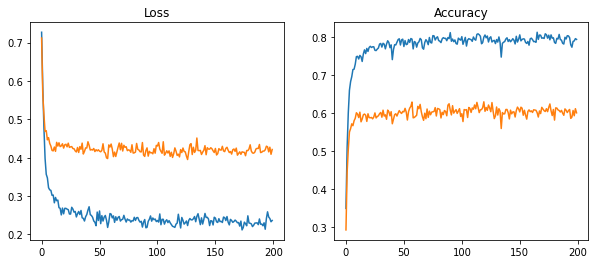

In [38]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].set_title("Loss")
ax[0].plot(training_history)
ax[0].plot(validation_history)

ax[1].set_title("Accuracy")
ax[1].plot(training_acc)
ax[1].plot(validation_acc)
# plt.savefig('/content/drive/MyDrive/Reviews_data/labelled_reviews/models/2.0/loss.png')

In [39]:
best_val_acc

tensor(0.6293)

## Evaluation

In [40]:
# filepath = '/content/drive/MyDrive/Reviews_data/labelled_reviews/models/clf.pth'
# net = Net(train_vectors.shape[1])
# net.load_state_dict(torch.load(filepath))
# thresh = 0.5

In [41]:
outputs_train = net(X_train)
outputs_train = (outputs_train>thresh).float()
for i, label in enumerate(labels):
    print(label)
    print(confusion_matrix(y_train[:,i], outputs_train[:,i]), '\n')

Functionality
[[2503   39]
 [  98  283]] 

User Experience
[[2199  132]
 [ 114  478]] 

Performance
[[2456   37]
 [  84  346]] 

Customer Support
[[2591   33]
 [  69  230]] 

Subscription
[[2796   11]
 [  18   98]] 

Feature Request
[[2536   26]
 [  70  291]] 



In [42]:
outputs_test = net(X_test)
outputs_test = (outputs_test>thresh).float()
for i, label in enumerate(labels):
    print(label)
    print(confusion_matrix(y_test[:,i], outputs_test[:,i]), '\n')

Functionality
[[848  41]
 [ 57  68]] 

User Experience
[[723  88]
 [ 68 135]] 

Performance
[[847  50]
 [ 45  72]] 

Customer Support
[[914  22]
 [ 35  43]] 

Subscription
[[983   8]
 [  8  15]] 

Feature Request
[[894  33]
 [ 28  59]] 



In [18]:
idxs_pred = np.where(outputs_test==1)
idxs_actual = np.where(y_test==1)

In [19]:
predicted_labels = [[] for _ in X_test]
for i in range(len(idxs_pred[0])):
  predicted_labels[idxs_pred[0][i]].append(labels[idxs_pred[1][i]])

actual_labels = [[] for _ in X_test]
for i in range(len(idxs_actual[0])):
  actual_labels[idxs_actual[0][i]].append(labels[idxs_actual[1][i]])


In [20]:
df_test = pd.DataFrame({'cleaned_text': test_corpus, 'actual_labels': actual_labels, 'predicted_labels': predicted_labels})
df_test

,cleaned_text,actual_labels,predicted_labels
0,nice app,[],[]
1,ideal,[],[]
2,after testing several alarm clock apps i have ...,"[Functionality, User Experience]","[Functionality, User Experience]"
3,too many adds,[User Experience],[User Experience]
4,very bad,[],[]
...,...,...,...
1009,good,[],[]
1010,beautiful very beautiful and what i want,[User Experience],[User Experience]
1011,application is good but ads disturb your calcu...,"[Functionality, User Experience]","[Functionality, User Experience]"
1012,great,[],[]
